# <span style="color:#006400">Portfolio of Outstanding Loans Analysis</span>

In [1]:
# Imports and config
import polars as pl
import pandas as pd
from pola import (
    MonthEndBalanceTabInfo,
    PaymentDueTabInfo,
    PaymentMadeTabInfo,
    PortfolioOfOutstandingLoans,
    StaticTabInfo,
    )

from pola import curves
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 15)
pl.Config.set_tbl_rows(20)

polars.config.Config

## Q1. Data as single dataframe

### Some comments
    Note each Tab of the SS might change format/layout in the future, depending on business case. So custom cleansing/formatting might apply in the future

    So we provide templates for ad hoc appending functionality. For example to read this Static tab we need to skip 2 rows and 1 column. If you have your own tab, just extend *pola.tabs.LoanDataTabInfo*. In the future this might change , it might even require a custom cleansing funciton. All this can be added without breaking changes.
    
    (This is a classic example of SOLID programming principles)




In [2]:
loans_data = PortfolioOfOutstandingLoans.from_excel(
    path="2024 - Strat Casestudy.xlsx",
    static_tab=StaticTabInfo("DATA-Static"),
    data_tabs=[
        MonthEndBalanceTabInfo("DATA-Month End Balances"),
        PaymentDueTabInfo("DATA-Payment Due"),
        PaymentMadeTabInfo("DATA-Payment Made"),
    ],
)

loans_data.all_data().head(10)
# You could also do:
# loans_data.data_df
# loans_data.static_df

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,pre_reversion_fixed_rate,post_reversion_boe_margin
0,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,2020-12-31,2020-12-31,2022-12-31,150876,1,0.019881,0.0375
1,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,2020-12-31,2020-12-31,2022-12-31,150876,1,0.019881,0.0375
2,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,2020-12-31,2020-12-31,2022-12-31,150876,1,0.019881,0.0375
3,2,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,2020-07-31,2020-12-31,2022-07-31,103580,1,0.019947,0.0375
4,2,Payment Made,NaN,NaN,NaN,NaN,NaN,...,2020-07-31,2020-12-31,2022-07-31,103580,1,0.019947,0.0375
5,2,Payment Due,NaN,NaN,NaN,NaN,NaN,...,2020-07-31,2020-12-31,2022-07-31,103580,1,0.019947,0.0375
6,3,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,2018-02-28,2020-12-31,2020-02-28,89311,1,0.029331,0.0375
7,3,Payment Made,NaN,NaN,NaN,NaN,NaN,...,2018-02-28,2020-12-31,2020-02-28,89311,1,0.029331,0.0375
8,3,Payment Due,NaN,NaN,NaN,NaN,NaN,...,2018-02-28,2020-12-31,2020-02-28,89311,1,0.029331,0.0375
9,4,Payment Due,NaN,NaN,NaN,NaN,NaN,...,2017-04-30,2020-12-31,2019-04-30,123170,1,0.027889,0.0375


### Some comments
    - Morgage monthly payments usually include an interest rate + face value repay amount. Looking at loan 1, payment due (eg 249.96) is just the interest , ie  ==  150,876.00 * (1.99%/12).

    - We don't have loan expiry date.

    


## Q2. Appending monthly metrics

### Some comments
    - Note: to save space, below we display only monthly data, not static
    - Month End balance is Current Balance(for Q2)
    - Method which starts with `add_` mutates the state of data by adding information. Be careful not to run twice. If you don't want to add data use method with similar name without `add_` (for example `.seasoning` instead of `.add_seasoning`). In the future the check "if already computed will be added".

In [3]:
# SEASONING
loans_data.add_seasoning().head(15)

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.00,0.00,0.00000,0.000000
0,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.000000,19.000000,20.000000,21.00,22.00,23.00000,24.000000
1,2,Payment Made,NaN,NaN,NaN,NaN,NaN,...,344.344992,172.172496,474.741667,517.90,517.90,582.63750,625.795833
1,2,Payment Due,NaN,NaN,NaN,NaN,NaN,...,172.172496,172.172496,474.741667,517.90,517.90,582.63750,625.795833
1,2,Seasoning,-55.0,-54.0,-53.0,-52.0,-51.0,...,23.000000,24.000000,25.000000,26.00,27.00,28.00000,29.000000
1,2,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,103580.000000,103580.000000,103580.000000,103580.00,103580.00,103580.00000,103580.000000
2,3,Payment Due,NaN,NaN,NaN,NaN,NaN,...,372.129167,372.129167,0.000000,0.00,0.00,0.00000,0.000000
2,3,Seasoning,-25.0,-24.0,-23.0,-22.0,-21.0,...,53.000000,54.000000,55.000000,56.00,57.00,58.00000,59.000000


In [4]:
# Note, first we do payment paid vs due. It's a fairly expensive calculation
# so best doing it once and then reusing the value
loans_data.add_payment_made_vs_due().head(15)

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.000000,19.000000,20.000000,21.0,22.0,23.0000,24.000000
0,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Payment Due,NaN,NaN,NaN,NaN,NaN,...,172.172496,172.172496,474.741667,517.9,517.9,582.6375,625.795833
1,2,Payment Made,NaN,NaN,NaN,NaN,NaN,...,344.344992,172.172496,474.741667,517.9,517.9,582.6375,625.795833
1,2,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,172.172496,0.000000,0.000000,0.0,0.0,0.0000,0.000000
1,2,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,103580.000000,103580.000000,103580.000000,103580.0,103580.0,103580.0000,103580.000000
1,2,Seasoning,-55.0,-54.0,-53.0,-52.0,-51.0,...,23.000000,24.000000,25.000000,26.0,27.0,28.0000,29.000000


In [5]:
# note we are reusing Payment Due vs Made
loans_data.add_n_missing_payments().head(15) # cummulative sum

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,1,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.000000,19.000000,20.000000,21.0,22.0,23.0000,24.000000
0,1,N missing payments,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Payment Due,NaN,NaN,NaN,NaN,NaN,...,172.172496,172.172496,474.741667,517.9,517.9,582.6375,625.795833
1,2,N missing payments,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.0,1.0,1.0000,1.000000
1,2,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,103580.000000,103580.000000,103580.000000,103580.0,103580.0,103580.0000,103580.000000
1,2,Seasoning,-55.0,-54.0,-53.0,-52.0,-51.0,...,23.000000,24.000000,25.000000,26.0,27.0,28.0000,29.000000


In [6]:
# Note Recovery is defined as any payments, even £1
# Default Month
loans_data.add_default_month().head(20)

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,1,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.000000,19.000000,20.000000,21.0,22.0,23.0000,24.000000
0,1,N missing payments,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,Is Default Month,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
1,2,Payment Due,NaN,NaN,NaN,NaN,NaN,...,172.172496,172.172496,474.741667,517.9,517.9,582.6375,625.795833
1,2,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,103580.000000,103580.000000,103580.000000,103580.0,103580.0,103580.0000,103580.000000
1,2,Is Default Month,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000


In [7]:
# And Use it to calc Recovery Payment
loans_data.add_is_recovery_payment().head(20)

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.000000,19.000000,20.000000,21.0,22.0,23.0000,24.000000
0,1,Is Recovery Payment,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,N missing payments,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Is Default Month,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Is Default Month,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
1,2,Is Recovery Payment,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000


In [8]:
# Post Seller Purchase Date
loans_data.add_is_post_seller_purchase_date().head(20)

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.000000,19.000000,20.000000,21.0,22.0,23.0000,24.000000
0,1,Is Default Month,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,N missing payments,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Is Recovery Payment,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,Is Post Seller Purchase,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.0,1.0,1.0000,1.000000
1,2,N missing payments,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.0,1.0,1.0000,1.000000


In [10]:
# Reversion - very similar to seasoning
loans_data.add_time_since_reversion().head(20)

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.000000,19.000000,20.000000,21.0,22.0,23.0000,24.000000
0,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,Is Recovery Payment,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Is Post Seller Purchase,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.0,1.0,1.0000,1.000000
0,1,Time Since Reversion,-84.0,-83.0,-82.0,-81.0,-80.0,...,-6.000000,-5.000000,-4.000000,-3.0,-2.0,-1.0000,0.000000
0,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,N missing payments,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Is Default Month,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
0,1,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000


## Q2 Appending Static Data

In [11]:
# Post Default Recoveries, Date of Default and Date of last Recovery Payment have already been computed
loans_data.static_df.head(10)

,loan_id,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,pre_reversion_fixed_rate,post_reversion_boe_margin,DefaultMonth,LastRecoveryMonth,RecoveredAmmount
0,1,2020-12-31,2020-12-31,2022-12-31,150876,1,0.019881,0.0375,None,None,NaN
1,2,2020-07-31,2020-12-31,2022-07-31,103580,1,0.019947,0.0375,None,None,NaN
2,3,2018-02-28,2020-12-31,2020-02-28,89311,1,0.029331,0.0375,2022-04-30,2022-07-31,88870.538079
3,4,2017-04-30,2020-12-31,2019-04-30,123170,1,0.027889,0.0375,None,None,NaN
4,5,2021-06-30,2021-06-30,2023-06-30,139657,1,0.019930,0.0375,None,None,NaN
5,6,2022-12-31,2022-12-31,2024-12-31,130943,1,0.063598,0.0375,None,None,NaN
6,7,2021-06-30,2021-06-30,2023-06-30,88026,1,0.022607,0.0375,None,None,NaN
7,8,2020-10-31,2020-12-31,2022-10-31,152709,1,0.022695,0.0375,None,None,NaN
8,9,2022-06-30,2022-06-30,2024-06-30,185855,1,0.045100,0.0375,None,None,NaN
9,10,2017-06-30,2020-12-31,2019-06-30,63897,1,0.025829,0.0375,None,None,NaN


In [12]:
# And BalanceAtDefault
loans_data.add_exposure_at_default().head(10)

,loan_id,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,pre_reversion_fixed_rate,post_reversion_boe_margin,DefaultMonth,LastRecoveryMonth,RecoveredAmmount,BalanceAtDefault
0,1,2020-12-31,2020-12-31,2022-12-31,150876,1,0.019881,0.0375,None,None,NaN,None
1,2,2020-07-31,2020-12-31,2022-07-31,103580,1,0.019947,0.0375,None,None,NaN,None
2,3,2018-02-28,2020-12-31,2020-02-28,89311,1,0.029331,0.0375,2022-04-30,2022-07-31,88870.538079,89311.0
3,4,2017-04-30,2020-12-31,2019-04-30,123170,1,0.027889,0.0375,None,None,NaN,None
4,5,2021-06-30,2021-06-30,2023-06-30,139657,1,0.019930,0.0375,None,None,NaN,None
5,6,2022-12-31,2022-12-31,2024-12-31,130943,1,0.063598,0.0375,None,None,NaN,None
6,7,2021-06-30,2021-06-30,2023-06-30,88026,1,0.022607,0.0375,None,None,NaN,None
7,8,2020-10-31,2020-12-31,2022-10-31,152709,1,0.022695,0.0375,None,None,NaN,None
8,9,2022-06-30,2022-06-30,2024-06-30,185855,1,0.045100,0.0375,None,None,NaN,None
9,10,2017-06-30,2020-12-31,2019-06-30,63897,1,0.025829,0.0375,None,None,NaN,None


In [13]:
# And Recovery Percent
loans_data.add_recovery_percent().head(10)

,loan_id,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,pre_reversion_fixed_rate,post_reversion_boe_margin,DefaultMonth,LastRecoveryMonth,RecoveredAmmount,BalanceAtDefault,RecoveryPercent
0,1,2020-12-31,2020-12-31,2022-12-31,150876,1,0.019881,0.0375,None,None,NaN,None,NaN
1,2,2020-07-31,2020-12-31,2022-07-31,103580,1,0.019947,0.0375,None,None,NaN,None,NaN
2,3,2018-02-28,2020-12-31,2020-02-28,89311,1,0.029331,0.0375,2022-04-30,2022-07-31,88870.538079,89311.0,0.995068
3,4,2017-04-30,2020-12-31,2019-04-30,123170,1,0.027889,0.0375,None,None,NaN,None,NaN
4,5,2021-06-30,2021-06-30,2023-06-30,139657,1,0.019930,0.0375,None,None,NaN,None,NaN
5,6,2022-12-31,2022-12-31,2024-12-31,130943,1,0.063598,0.0375,None,None,NaN,None,NaN
6,7,2021-06-30,2021-06-30,2023-06-30,88026,1,0.022607,0.0375,None,None,NaN,None,NaN
7,8,2020-10-31,2020-12-31,2022-10-31,152709,1,0.022695,0.0375,None,None,NaN,None,NaN
8,9,2022-06-30,2022-06-30,2024-06-30,185855,1,0.045100,0.0375,None,None,NaN,None,NaN
9,10,2017-06-30,2020-12-31,2019-06-30,63897,1,0.025829,0.0375,None,None,NaN,None,NaN


In [14]:
# Assuming Loan repays when we first hit Month End Balance == 0
loans_data.add_prepayment_date().head(10)

,loan_id,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,pre_reversion_fixed_rate,post_reversion_boe_margin,DefaultMonth,LastRecoveryMonth,RecoveredAmmount,BalanceAtDefault,RecoveryPercent,PrepaymentDate
0,1,2020-12-31,2020-12-31,2022-12-31,150876,1,0.019881,0.0375,None,None,NaN,None,NaN,2021-08-31
1,2,2020-07-31,2020-12-31,2022-07-31,103580,1,0.019947,0.0375,None,None,NaN,None,NaN,NaN
2,3,2018-02-28,2020-12-31,2020-02-28,89311,1,0.029331,0.0375,2022-04-30,2022-07-31,88870.538079,89311.0,0.995068,2022-07-31
3,4,2017-04-30,2020-12-31,2019-04-30,123170,1,0.027889,0.0375,None,None,NaN,None,NaN,NaN
4,5,2021-06-30,2021-06-30,2023-06-30,139657,1,0.019930,0.0375,None,None,NaN,None,NaN,NaN
5,6,2022-12-31,2022-12-31,2024-12-31,130943,1,0.063598,0.0375,None,None,NaN,None,NaN,NaN
6,7,2021-06-30,2021-06-30,2023-06-30,88026,1,0.022607,0.0375,None,None,NaN,None,NaN,2022-11-30
7,8,2020-10-31,2020-12-31,2022-10-31,152709,1,0.022695,0.0375,None,None,NaN,None,NaN,NaN
8,9,2022-06-30,2022-06-30,2024-06-30,185855,1,0.045100,0.0375,None,None,NaN,None,NaN,NaN
9,10,2017-06-30,2020-12-31,2019-06-30,63897,1,0.025829,0.0375,None,None,NaN,None,NaN,2021-10-31


## Extras

In [15]:
# For CDR(Default Curve) it's good to know if a loan is Active
loans_data.add_is_active().head(10)

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
6,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1,Time Since Reversion,-84.0,-83.0,-82.0,-81.0,-80.0,...,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0
9,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.0,19.0,20.0,21.0,22.0,23.0,24.0
5,1,N missing payments,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Is Default Month,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Is Post Seller Purchase,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,BalanceAtDefault,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# For Recovery Curve good to cumulative recovery
loans_data.add_cummulative_recovery_payments().head(40)

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
6,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.000000,19.000000,20.000000,21.000000,22.000000,23.000000,24.000000
4,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,1,Cummulative Recovery,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1,N missing payments,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,Is Post Seller Purchase,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
10,1,Time Since Reversion,-84.0,-83.0,-82.0,-81.0,-80.0,...,-6.000000,-5.000000,-4.000000,-3.000000,-2.000000,-1.000000,0.000000
0,1,BalanceAtDefault,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
# For Recovery Curve good to have
loans_data.add_time_since_default().head(15)

,loan_id,Data,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,...,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,1,Time Since Default,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Month End Balance,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
6,1,Payment Due,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,Payment Made,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,Seasoning,-60.0,-59.0,-58.0,-57.0,-56.0,...,18.000000,19.000000,20.000000,21.0,22.0,23.0000,24.000000
8,1,Payment Made vs Due,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
17930,1,Is Active,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.0,1.0,1.0000,1.000000
0,1,Cummulative Recovery,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
1,1,Is Default Month,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000
5,1,N missing payments,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.000000


# Q3-7 Curves
### Dev comments
    - Curves vary alot by their nature (rate, corr, ) - all of them are built using different data points and have different uses. That's why we provide *pola.curves.Curve* as an abstract class which takes care of distribution of pivots and other common tasks. But each (new) curve MUST implement *build_from_portfolio* (in the future this method should take **kwargs as arg to allow for maximum flexibility). Curves can override *__init__* and other methods depending on the usecase, data etc
    - Note a single use function should return same datatype with or without pivots. So we return DataFrame always

# CPR (Prepayment Curve) estimates rate at which borrower prepay their loans

For a portfolio of loans, the CPR is an annualized percentage rate that indicates the proportion of the remaining principal that is expected to be prepaid over a specified period.

Formula:
###     [for each seasoning] Sum prepayment / Sum outstanding principal  

Note, tis is not the same as `Sum of (prepayment/outstanding principle) [for each seasoning]`, which computes at individual loan level and sums.

```
s1 p11 o11
s2 p12 o12
s1 p21 o21
s2 p22 o22

(p11 + p21) / (o11 + o21) << p11/o11 + p21/o21

```


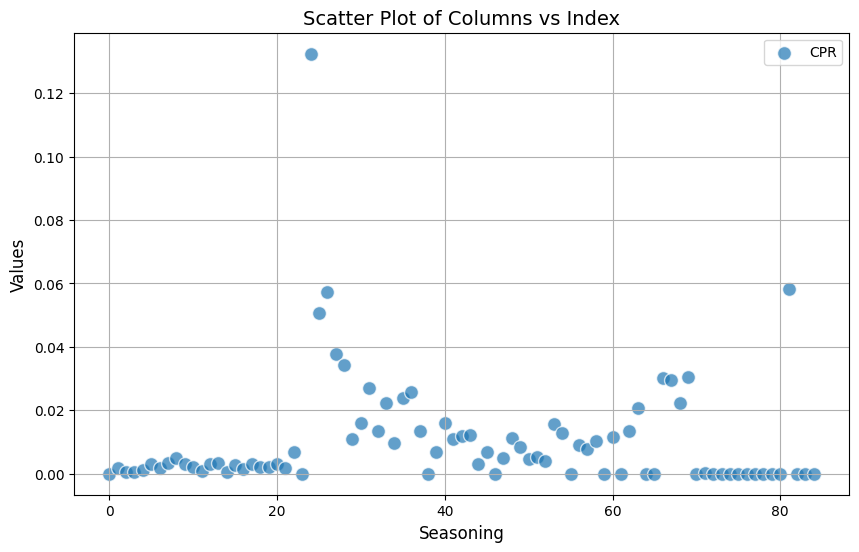

In [19]:
cpr_curve = curves.CPR(loans_data)
cpr_curve.show()

### Some comments
Where `Prepayment is 0` creates noise on the curve, but is part of data

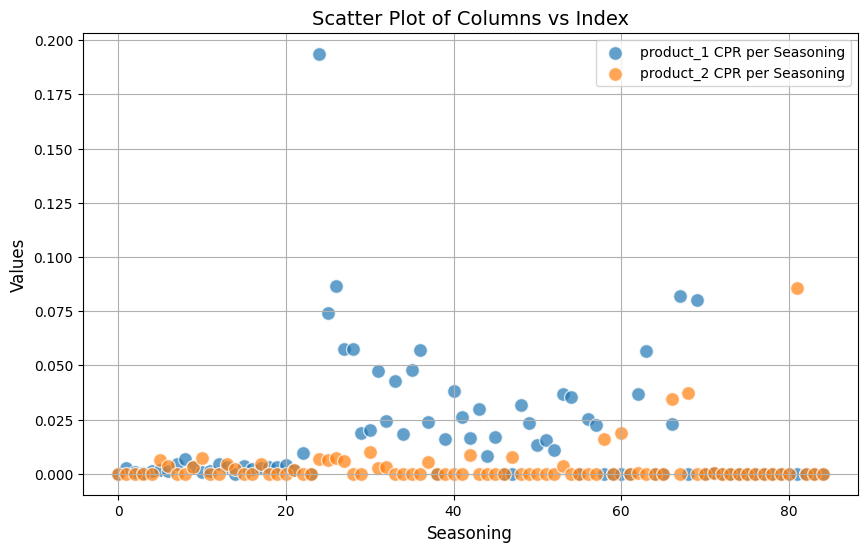

In [20]:
# With pivot on Product - scroll down to see both
cpr_curve = curves.CPR(loans_data, pivots=["product"])
cpr_curve.show()

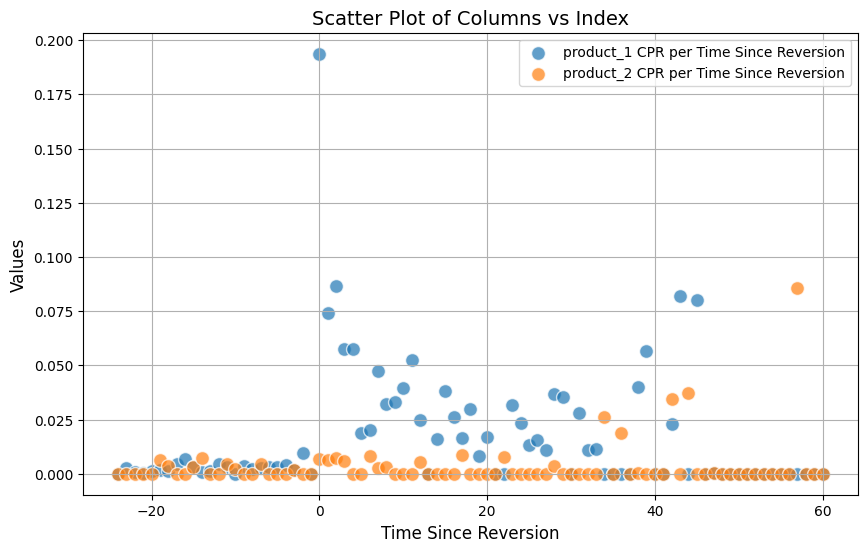

In [21]:
# With index on Time to Reversion and pivot on Product
# Note, for Time to Reversion we do not want to filter out 0s
cpr_curve = curves.CPR(loans_data, index='Time Since Reversion',pivots=["product"], filter_gt_0=False)
cpr_curve.show()

### Some comments
Reversion is recent(mostly 22-24), and likely Interest Rates increased post reversion, as currently FED and BOE rates are much higher than before the pandemic. So we see alot of repayments **after** the reversion.

# Default Curve 
### N of defaults / total N of Active (Originated and Not in Default) loans for each seasoning

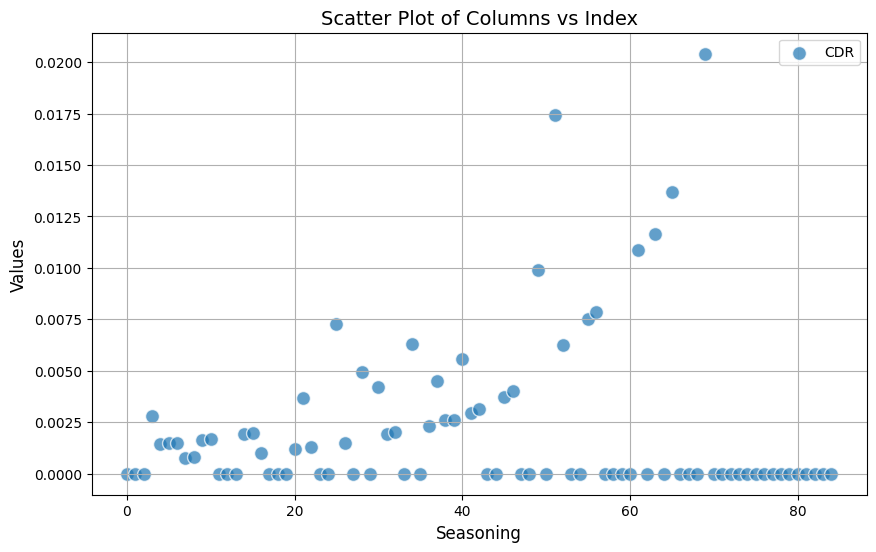

In [22]:

cdr_curve = curves.CDR(loans_data)
cdr_curve.show()

### Some comments
`N of defaults / total N of Active (Originated and Not in Default) loans for each seasoning` might not be the best logic, since N of Active loans dicreases.

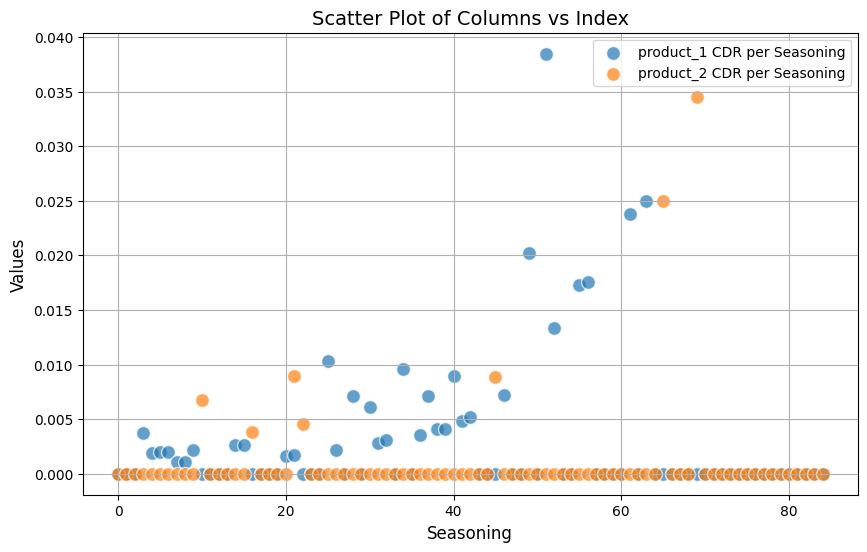

In [23]:
cdr_curve = curves.CDR(loans_data, pivots=["product"])
cdr_curve.show()

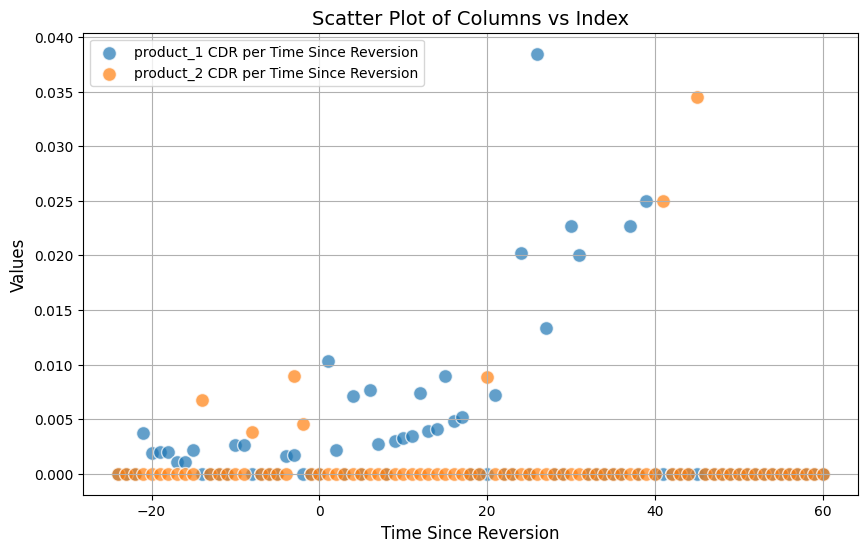

In [24]:
cdr_curve = curves.CDR(loans_data, index='Time Since Reversion',pivots=["product"], filter_gt_0=False)
cdr_curve.show()

# Recovery Curve
Formula:

### [For each Time to Default]  sum of cummulative recovery payments / Sum BalanceAtDefault

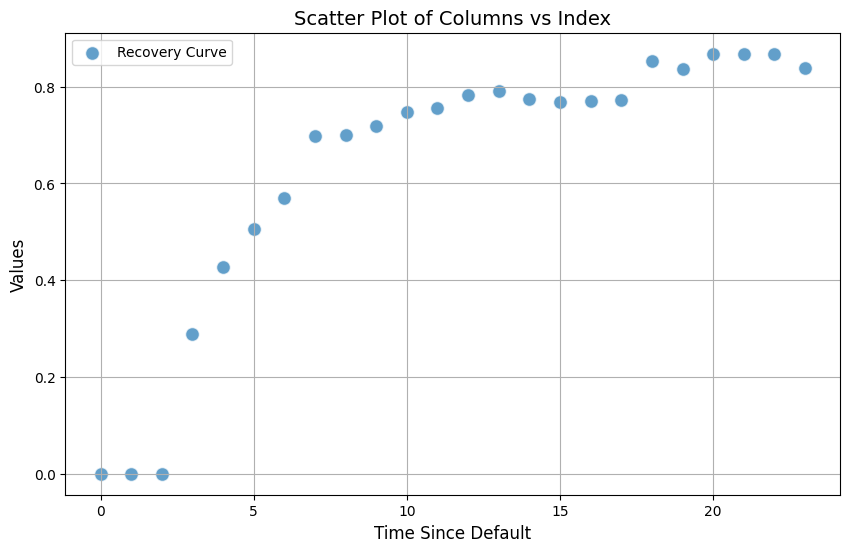

In [25]:
# Work In Progress - almost complete
recovery_curve = curves.RecoveryCurve(loans_data, index='Time Since Default')
recovery_curve.show()

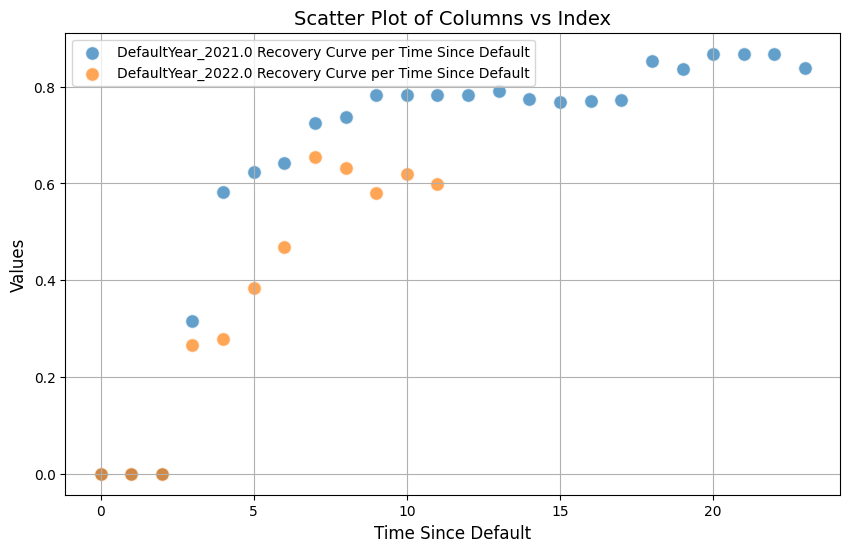

In [42]:
# Recovery Curve
loans_data.static_df["DefaultYear"] = pd.to_datetime(loans_data.static_df['DefaultMonth']).dt.year
recovery_curve = curves.RecoveryCurve(loans_data, index='Time Since Default', pivots=['DefaultYear'])
recovery_curve.show()

### `Probability of recovery per month since default`

Recovery is defined as any payment post default

- does this mean `Probability of getting any payment per month since default`? If so, then the formula is [per Months since default]  N of payments / sum of defaulted loans

### TODO
 - Interesting to see avg rate for defaulted loand vs avg rate for non defaulted/repayed early

# TimeoutError
# Thank you for reading to the end. TBC.